# STATISTICS

# Patterns and relationships
# Correlation Analysis

Libraries:
- pandas
- numpy
- scipy

## 1. Pearson and Spearman coefficients for real data

### Illiteracy VS fertility

Is there a correlation between illiteracy and childbirth? For 94 countries with a female illiteracy rate of more than 5%, the percentage of illiterate women over 15 (for 2003) and the average birth rate per woman (for 2005) are known.

In [1]:
import pandas as pd
data = pd.read_csv('illiteracy.txt', sep='\t')
data.head()

,Country,Illit,Births
0,Albania,20.5,1.78
1,Algeria,39.1,2.44
2,Bahrain,15.0,2.34
3,Belize,5.9,2.97
4,Benin,73.5,5.60


In [2]:
data.describe()

,Illit,Births
count,94.000000,94.000000
mean,31.473404,3.664787
std,22.348622,1.585262
min,5.400000,0.880000
25%,13.325000,2.392500
50%,22.650000,3.370000
75%,49.325000,4.960000
max,90.200000,7.670000


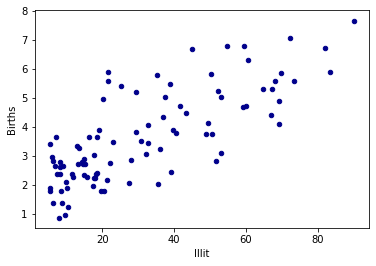

In [4]:
data.plot.scatter(x='Illit', y='Births', c='DarkBlue')

In [5]:
# Pearson coefficient

corrP = data.corr()
corrP

,Illit,Births
Illit,1.000000,0.768663
Births,0.768663,1.000000


In [6]:
# Spearman coefficient

corrS = data.corr(method = 'spearman')
corrS

,Illit,Births
Illit,1.000000,0.752962
Births,0.752962,1.000000


### Water hardness VS mortality

For 61 large cities in England and Wales, the average annual mortality per 100,000 population (according to 1958–1964) and the concentration of calcium in drinking water (in parts per million) are known. The higher the concentration of calcium, the harder the water. Cities are further divided into northern and southern.

Is there a relationship between the hardness of the water and the average annual mortality?

In [7]:
data = pd.read_csv('water.txt', delimiter="\t")
data.head()

,location,town,mortality,hardness
0,South,Bath,1247,105
1,North,Birkenhead,1668,17
2,South,Birmingham,1466,5
3,North,Blackburn,1800,14
4,North,Blackpool,1609,18


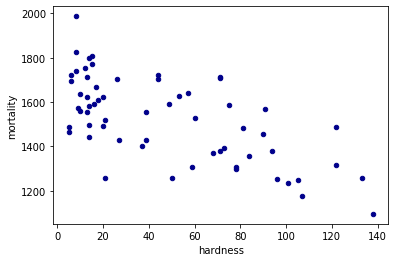

In [8]:
data.plot.scatter(x='hardness', y='mortality', c='DarkBlue')

In [9]:
# Pearson coefficient

corrP = data.corr()
corrP

,mortality,hardness
mortality,1.000000,-0.654849
hardness,-0.654849,1.000000


Is the relationship between the signs preserved if the sample is divided into northern and southern cities?

In [10]:
data_sur = data.loc[(data['location'] == 'South')]
data_nord = data.loc[(data['location'] == 'North')]

In [11]:
data_sur.corr()

,mortality,hardness
mortality,1.000000,-0.602153
hardness,-0.602153,1.000000


In [12]:
data_nord.corr()

,mortality,hardness
mortality,1.000000,-0.368598
hardness,-0.368598,1.000000


## 2. Matthews coefficient for binary data

###  Bar visits frequency

Among respondents to the 2014 General Social Survey, at least once a month, 203 women and 239 men spend an evening at the bar; less than once a month, 718 women and 515 men do it.

Let's calculate the value of the Matthews correlation coefficient between gender and the frequency of going to bars.

Contingency table:

   |     | $X_1$  | $X_2$ 
  ------------- | -------------| -------------|
  1  | a | b 
  0  | c | d 
  $\sum$  | $n_1$| $n_2$

Matthews correlation coefficient:

$$MCC({X_1, X_2}) =  \frac{a·d - b·c}{\sqrt{(a+b)(a+c)(b+d)(c+d)}}$$

   |     | $H$  | $M$ 
  ------------- | -------------| -------------|
  1  | 239 | 203 
  0  | 515 | 718 
  $\sum$  | $754$| $921$

In [13]:
import numpy as np
H = np.append(np.ones(239), np.zeros(515))    # X1
M = np.append(np.ones(203), np.zeros(718))    # X2

In [14]:
def corr_matthews(sample1, sample2):
    a = sample1.sum()
    b = sample2.sum()
    c = len(sample1)-sample1.sum()
    d = len(sample2)-sample2.sum()
    return (a*d - b*c)/((a+b)*(a+c)*(b+d)*(c+d))**0.5

In [15]:
round(corr_matthews(H, M), 4)

0.109

The correlation coefficient is not too high. Let's check if the Matthews correlation coefficient is significantly different from zero using function _scipy.stats.chi2_contingency._

In [16]:
from scipy.stats import chi2_contingency

In [17]:
# Observed frequencies

obs_f = np.array([[239, 203], [515, 718]])
obs_f

array([[239, 203],
       [515, 718]])

H0: corr_matthews = 0

H1: corr_matthews != 0

In [18]:
test = chi2_contingency(obs_f)
chi2, p, df, expect_f = test
expect_f  # expected frequencies

array([[198.96597015, 243.03402985],
       [555.03402985, 677.96597015]])

In [19]:
print('p-value: ', p)

p-value:  1.0558987006638725e-05


p < 0.05, --> H1:  Matthews correlation coefficient differs from zero.

Let's try to answer a slightly different question: does the proportion of men and the proportion of women spend evenings at the bar differ? For this, we will construct a 95% confidence interval for the difference in proportions.

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Confidence interval for: }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-statistics: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [20]:
from scipy import stats

In [21]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [22]:
print('proportion of men:  ', 239/754)
print('proportion of women: ', 203/921)

proportion of men:   0.3169761273209549
proportion of women:  0.22041259500542887


In [23]:
print('95% confidence interval for the difference: ', proportions_diff_confint_ind(H, M))

95% confidence interval for the difference:  (0.053905233215813156, 0.13922183141523897)


As we can see, the interval doesn't contains zero.

Ultimately, we check the hypothesis of equality of shares lovers often spend their evenings in the bar for both men and women, using a two-way alternative.

In [24]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [25]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

H0: p1 = p2
    
H1: p1 != p2

In [26]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(H, M)))

p-value: 0.000008


p < 0.05, --> H1:  men and women doesn't spend the same time in the bars.

## 3. V Cramer for categorical data

### Happiness VS finance

Let's look at the 2014 General Social Survey data and analyze how relate the answers to the questions "Are you happy?" and "Are you satisfied with your financial situation?"

  X_1/ X_2 | Dissatisfied | More or less | Satisfied
  ------------- | -------------|------------- | -------------|
  **Not very happy**  | $197$ | $111$| $33$ 
  **Happy enough** | $382$  | $685$ | $331$  
  **Very happy** | $110$  | $342$ | $333$ 

We'll calculate value of chi-square statistics for this contingency table.

In [27]:
obs_f = np.array([[197, 111, 33], [382, 685, 331], [110, 342, 333]])

In [28]:
chi2, p, df, expect_f = chi2_contingency(obs_f)
print('p-value: ', p)

p-value:  2.4964299580093467e-62


p << 0.05, H1: we can conclude that there is some relationship in our data, but that doesn’t mean that she’s big. Let's calculate V Cramer coefficient then.

$$ VC = \sqrt{\frac{Chi_2({X_1, X_2})}{n((min(K_1, K_2)-1)}}$$

In [29]:
def VC(obs_freq):
    #import numpy as np
    #from scipy.stats import chi2_contingency
    chi2, p, df, expect_f = chi2_contingency(obs_freq)
    n = obs_f.sum()
    return np.sqrt(chi2 / (n*(min(obs_freq.shape)-1)))   

In [30]:
print('V Cramer: ', VC(obs_f))

V Cramer:  0.2412013934500338
